In [1]:
from pathlib import Path
from datetime import datetime
import json
import simplejson

# BASE_FOLDER = './experiments/message_mutation_temp_annealing'
# EXPERIMENT_FOLDER = f'{BASE_FOLDER}/{datetime.now().strftime("%d-%m_%H-%M")}'
EXPERIMENT_FOLDER = "./experiments/message_mutation_2"

In [2]:
Path(EXPERIMENT_FOLDER).mkdir(exist_ok=True)
EXPERIMENT_FOLDER

'./experiments/message_mutation_2'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [5]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [6]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [7]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [8]:
def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 
        'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_unkind_mutation_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate, 
        'kind_mutations': False,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=125, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 100
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

## Investigating the effect of message mutation:

In [9]:
class VaryPMutateExperiment(MetaExperiment):
    
    def __init__(self, 
                 num_intervals=5, 
                 save_location=None, 
                 **experiment_kwargs):
        self.num_experiments = num_intervals + 1
        self.name = 'vary_pm_experiment'
        
        p_mutate_vals = [
            i/num_intervals for i in range(self.num_experiments)
        ]
        self.experiments = [
            {
                'p_mutate': p_mutate,
                'experiment': MetaExperiment(
                    p_mutate=p_mutate, 
                    print_prehistory=self.print_history,
                    name=f'meta_experiment_pm={p_mutate}',
                    export_location=None if save_location is None else \
                                    f'{save_location}/pm={p_mutate}',
                    **experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i, p_mutate in enumerate(p_mutate_vals)
        ]
        
        self.save_location = save_location
        if save_location is not None:
            self.load_history(save_location)
    
    def get_experiment_results(self, meta_experiment):
        return meta_experiment.results

    def _get_results(self):
        return None
    
    def print_prehistory(self):
        pass
            
    def load_history(self, history_location):
        experiment_path = Path(history_location)
        for path in experiment_path.glob('*'):
            try:
                metadata = json.load((path / 'meta.json').open(mode='r'))
                results = json.load((path / 'results.json').open(mode='r'))
                i = metadata['index']
                self.experiments[i]['status'] = 'Complete'
                self.experiments[i]['results'] = results['zs_coord_f1_scores']
                meta_exp = self.experiments[i]['experiment']
                meta_exp.results = results['zs_coord_f1_scores']

                for item in meta_exp.experiments:
                    history_path = path / f"experiment_{item['index']}_logs.json"
                    training_history = json.load(history_path.open(mode='r'))
                    item['experiment'].training_history = training_history
            except FileNotFoundError:
                pass
    
    def export_experiment(self, experiment):
        if self.save_location is not None:
            experiment_config = \
                experiment.experiments[0]['experiment'].get_config()
            
            i, *_ = [i for i, x in enumerate(self.experiments)
                     if x['experiment'] == experiment]
            meta_data = {
                'index': i,
                'experiment_config': experiment_config
            }
            meta_data_path = Path(f'{experiment.export_location}/meta.json')
            with meta_data_path.open(mode='w') as f:
                json.dump(meta_data, f)
                
            results = {
                'zs_coord_f1_scores': experiment.results
            }
            results_path = Path(f'{experiment.export_location}/results.json')
            with results_path.open(mode='w') as f:
                json.dump(results, f)

            print('Saved experiment data at:', experiment.export_location)

In [10]:
vary_pm_experiment = VaryPMutateExperiment(save_location=EXPERIMENT_FOLDER,
                                           create_experiment_fn=create_mutation_with_temp_annealing_experiment)

In [11]:
vary_pm_experiment.run()

Running vary_pm_experiment...
meta_experiment_pm=0.0 results:  [0.6125, 0.4125, 0.59375, 0.675, 0.6625, 0.425]
meta_experiment_pm=0.2 results:  [0.3125, 0.4125, 0.36250000000000004, 0.1375, 0.36250000000000004, 0.66875]
meta_experiment_pm=0.4 results:  [0.225, 0.425, 0.23125, 0.35, 0.08125, 0.01875]
meta_experiment_pm=0.6 results:  [0.3875, 0.65625, 0.33125, 0.6875, 0.375, 0.66875]
meta_experiment_pm=0.8 results:  [0.23125, 0.59375, 0.29375, 0.38125, 0.65, 0.45625]
meta_experiment_pm=1.0 results:  [0.2875, 0.33125, 1.0, 1.0, 0.3, 0.325]
Run Stopped.


In [23]:
df = pd.DataFrame([
    {
        'Mutation Probability': item['p_mutate'],
        'Zero-Shot Coordination Score': score,
    }
    for item in vary_pm_experiment.experiments
    if item['status'] == 'Complete'
    for score in item['results']
])

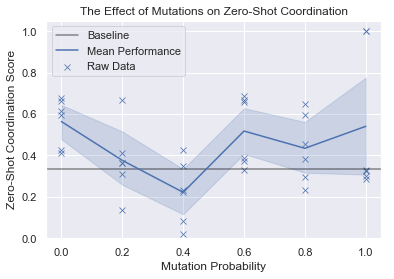

In [13]:
sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], dashes=True, color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, label='Mean Performance')
sns.scatterplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, marker='x', label='Raw Data')
plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.show()

In [35]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"p_m={item_1['p_mutate']}",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Train Loss': training_item['loss']
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history) 
])
df_train.head()

,Epoch,Experiment,Subexperiment,Train Loss
0,0,p_m=0.0,subexperiment_0,2.195620
1,1,p_m=0.0,subexperiment_0,1.133954
2,2,p_m=0.0,subexperiment_0,1.022720
3,3,p_m=0.0,subexperiment_0,0.945419
4,4,p_m=0.0,subexperiment_0,0.889458


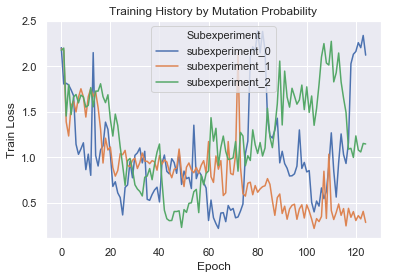

In [48]:
sns.lineplot(x='Epoch', y='Train Loss', hue='Subexperiment', 
             data=df_train[df_train['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training History by Mutation Probability')
plt.show()

In [49]:
df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"p_m={item_1['p_mutate']}",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'F1-Score': training_item['test_metrics']['mean_ground_truth_f1']
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history)
    if 'test_metrics' in training_item
])

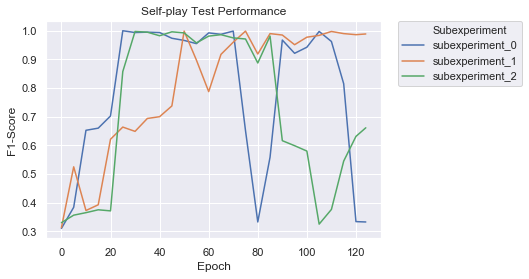

In [50]:
sns.lineplot(x='Epoch', y='F1-Score', hue='Subexperiment', 
             data=df_test[df_test['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Self-play Test Performance')
plt.show()

In [18]:
vary_pm_experiment.experiments[0]['experiment'].results

[0.6125, 0.4125, 0.59375, 0.675, 0.6625, 0.425]

In [51]:
games_played, test_metrics = vary_pm_experiment.experiments[2]['experiment'].experiments[1]['experiment'].run_tests()
test_metrics

{'mean_test_loss': 6.599236011505127,
 'mean_ground_truth_f1': 0.99,
 'ground_truth_acc': 0.99,
 'mean_student_error': 0.5180599093437195,
 'mean_teacher_error': 4.918673515319824,
 'mean_protocol_diversity': 0.918749988079071}

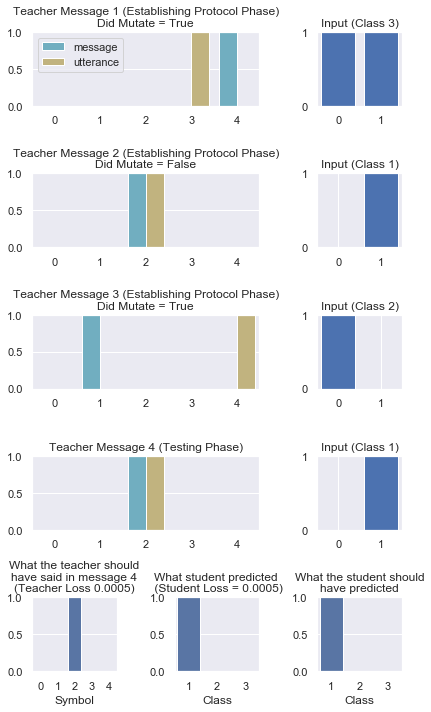

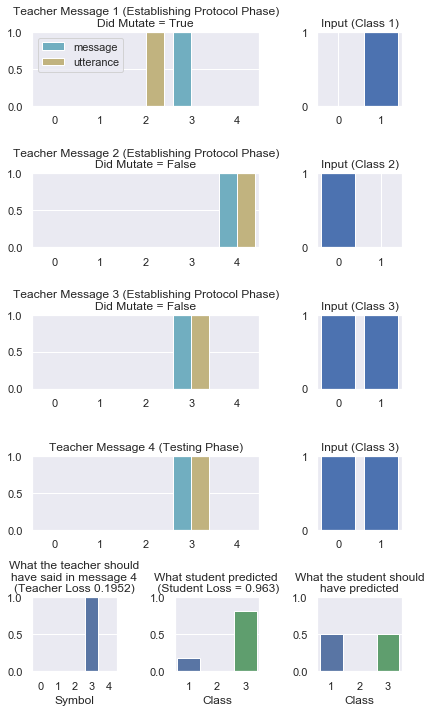

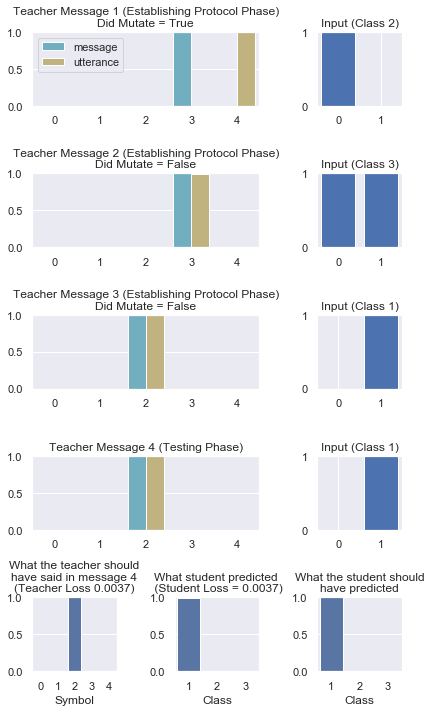

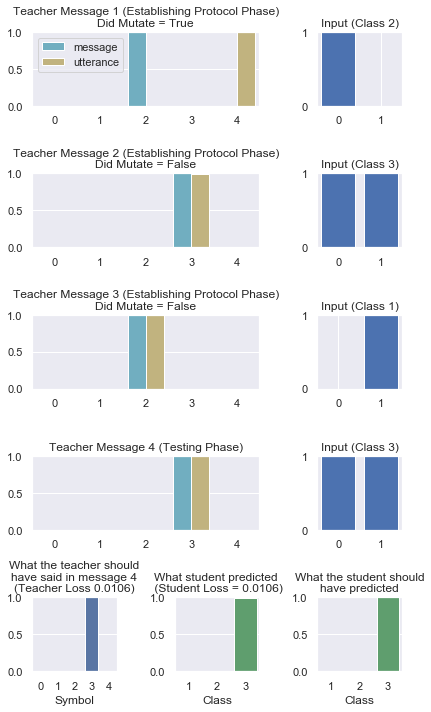

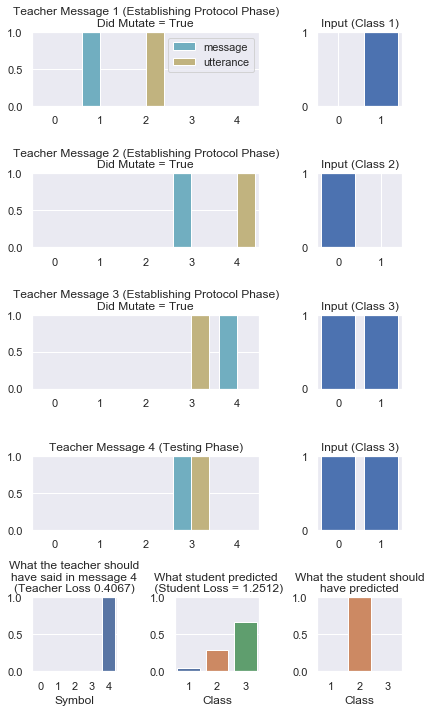

In [52]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=1)

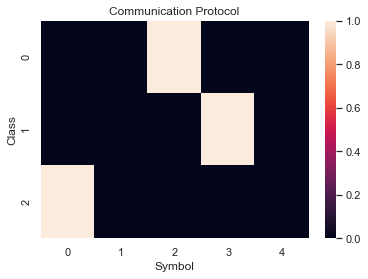

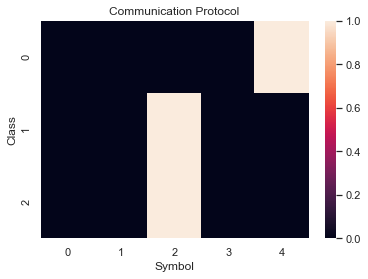

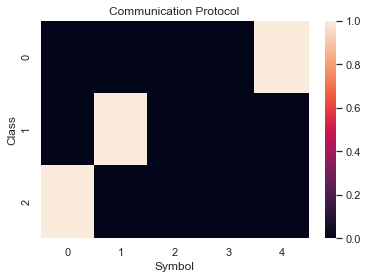

In [45]:
for i in range(3):
    games_played, _ = vary_pm_experiment.experiments[0]['experiment'].experiments[i]['experiment'].run_tests()
    mean_class_message_map = create_mean_class_message_map(games_played)
    sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
    plt.ylabel('Class')
    plt.xlabel('Symbol')
    plt.title('Communication Protocol')
    plt.show()

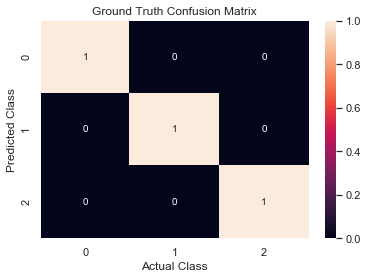

In [22]:
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');